In [6]:
# # config.py
# import torch

# config = {
#     'train_monkeypox_dir': '/kaggle/input/augmented-monkeypox-dataset/augmented_dataset/monkeypox/train_monkeypox',
#     'test_monkeypox_dir': '/kaggle/input/augmented-monkeypox-dataset/augmented_dataset/monkeypox/test_monkeypox',
#     'train_other_dir': '/kaggle/input/augmented-monkeypox-dataset/augmented_dataset/Other/train_other',
#     'test_other_dir': '/kaggle/input/augmented-monkeypox-dataset/augmented_dataset/Other/test_other',
    
#     'batch_size': 32,
#     'num_workers': 4,
#     'image_size': 128,      # width and height are 128
#     'num_classes': 2,       # binary classification: monkeypox vs other
#     'epochs': 10,
#     'learning_rate': 1e-4,
#     'seed': 42,
#     'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
# }

# print("DEVICE =", config['device'])


DEVICE = cuda


In [18]:
# config.py
import torch

config = {
    'train_monkeypox_dir': '/kaggle/input/modified-augmented-dataset/modified_augmented_dataset/monkeypox/train_monkeypox',
    'test_monkeypox_dir': '/kaggle/input/modified-augmented-dataset/modified_augmented_dataset/monkeypox/test_monkeypox',
    'train_other_dir': '/kaggle/input/modified-augmented-dataset/modified_augmented_dataset/Other/train_other',
    'test_other_dir': '/kaggle/input/modified-augmented-dataset/modified_augmented_dataset/Other/test_other',
    
    'batch_size': 32,
    'num_workers': 4,
    'image_size': 128,      # width and height are 128
    'num_classes': 2,       # binary classification: monkeypox vs other; 0 - monkeypox, 1 - other
    'epochs': 57, # 101, # 10, 33,
    'learning_rate': 1e-4,
    'seed': 42,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

print("DEVICE =", config['device'])


DEVICE = cuda


## Dataloaders

In [12]:
# data_loader.py
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, monkeypox_dir, other_dir, transform=None):
        # Use minimal transform: just convert image to tensor
        self.transform = transform if transform is not None else transforms.ToTensor()
        self.images = []
        self.labels = []
        
        # load monkeypox images (assign label 0)
        monkeypox_files = [os.path.join(monkeypox_dir, f) 
                           for f in os.listdir(monkeypox_dir) 
                           if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        self.images.extend(monkeypox_files)
        self.labels.extend([0] * len(monkeypox_files))
        
        # load Other images (assign label 1)
        other_files = [os.path.join(other_dir, f) 
                       for f in os.listdir(other_dir) 
                       if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        self.images.extend(other_files)
        self.labels.extend([1] * len(other_files))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path).convert("RGB")
        # images are already 128x128; so no additional resizing needed.
        image = self.transform(image)
        label = self.labels[index]
        return image, label

# create train and test datasets
train_dataset = CustomDataset(config['train_monkeypox_dir'], config['train_other_dir'])
test_dataset = CustomDataset(config['test_monkeypox_dir'], config['test_other_dir'])

# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'])
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'])

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))


Number of training samples: 1226
Number of testing samples: 528


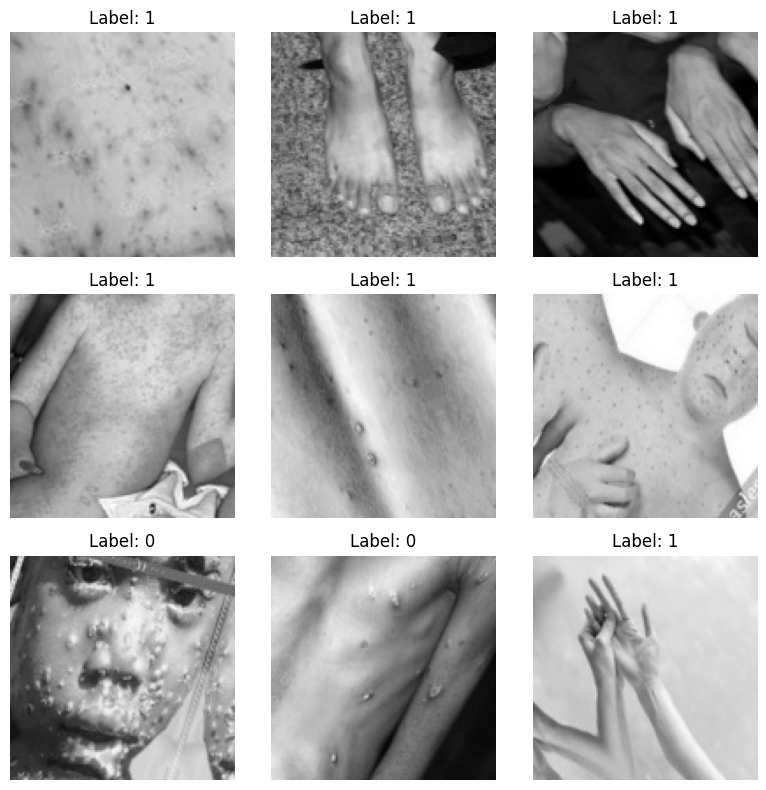

In [13]:
# visualization.py
import matplotlib.pyplot as plt
import numpy as np

# Fetch one batch from the training loader
images, labels = next(iter(train_loader))

# convert tensor images to numpy arrays for plotting
images = images.numpy().transpose((0, 2, 3, 1))

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
plt.tight_layout()
plt.show()


In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
# model_architecture.py
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary

# load EfficientNetB4 pre-trained on ImageNet
model = models.efficientnet_b4(pretrained=True)

# modify the classifier to match the number of classes
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, config['num_classes'])

# move the model to the specified device
model = model.to(config['device'])

# print model summary
print("Model Summary:")
summary(model, (3, config['image_size'], config['image_size']))


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 64, 64]           1,296
       BatchNorm2d-2           [-1, 48, 64, 64]              96
              SiLU-3           [-1, 48, 64, 64]               0
            Conv2d-4           [-1, 48, 64, 64]             432
       BatchNorm2d-5           [-1, 48, 64, 64]              96
              SiLU-6           [-1, 48, 64, 64]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12           [-1, 48, 64, 64]               0
           Conv2d-13           [-1, 24, 64, 64]           1,152
      BatchNorm2d-14    

In [43]:
import wandb

wandb.login(key="43ba0e8a2e5913526b62f3733783d0f493c6c39a") 

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [44]:
# create your wandb run
run = wandb.init(
    name    = "dnyaboke_project_run8",
    reinit  = True,
    entity = 'delta-team',
    project = "final-project-ablations",
    config  = config 
)

In [37]:
# # training.py
# import torch
# import torch.nn as nn
# import torch.optim as optim

# from tqdm import tqdm

# # define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# def evaluate_on_test(model, loader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     with torch.no_grad():
#         for images, labels in loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             running_loss += loss.item() * images.size(0)
#             _, preds = torch.max(outputs, 1)
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)
    
#     epoch_loss = running_loss / total
#     epoch_acc = correct / total
#     return epoch_loss, epoch_acc

# # arrays to store metrics for plotting
# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []


# def train_one_epoch(epoch, model, loader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     for images, labels in tqdm(loader, desc=f"Epoch {epoch+1}"):
#         images, labels = images.to(device), labels.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item() * images.size(0)
#         _, preds = torch.max(outputs, 1)
#         correct += (preds == labels).sum().item()
#         total += labels.size(0)
    
#     epoch_loss = running_loss / total
#     epoch_acc = correct / total
#     print(f"Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

#      # log training metrics to wandb for this epoch
#     wandb.log({
#         "Epoch": epoch + 1,
#         "Train Loss": epoch_loss,
#         "Train Accuracy": epoch_acc
#     })
    
#     # Save a checkpoint
#     checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
#     torch.save(model.state_dict(), checkpoint_path)
#     wandb.save(checkpoint_path)

# # training loop
# for epoch in range(config['epochs']):
#     train_one_epoch(epoch, model, train_loader, criterion, optimizer, config['device'])


Epoch 1: 100%|██████████| 39/39 [00:06<00:00,  6.05it/s]


Train Loss: 0.3376, Accuracy: 0.8401


Epoch 2: 100%|██████████| 39/39 [00:05<00:00,  6.73it/s]


Train Loss: 0.3102, Accuracy: 0.8622


Epoch 3: 100%|██████████| 39/39 [00:05<00:00,  6.73it/s]


Train Loss: 0.2821, Accuracy: 0.8793


Epoch 1: 100%|██████████| 39/39 [00:05<00:00,  6.71it/s]

Train Loss: 0.2347, Accuracy: 0.9144


Val Loss: 0.5260, Val Accuracy: 0.7443


Epoch 2: 100%|██████████| 39/39 [00:05<00:00,  6.72it/s]

Train Loss: 0.2170, Accuracy: 0.9111


Val Loss: 0.5793, Val Accuracy: 0.7386


Epoch 3: 100%|██████████| 39/39 [00:05<00:00,  6.85it/s]

Train Loss: 0.1998, Accuracy: 0.9225


Val Loss: 0.5815, Val Accuracy: 0.7462


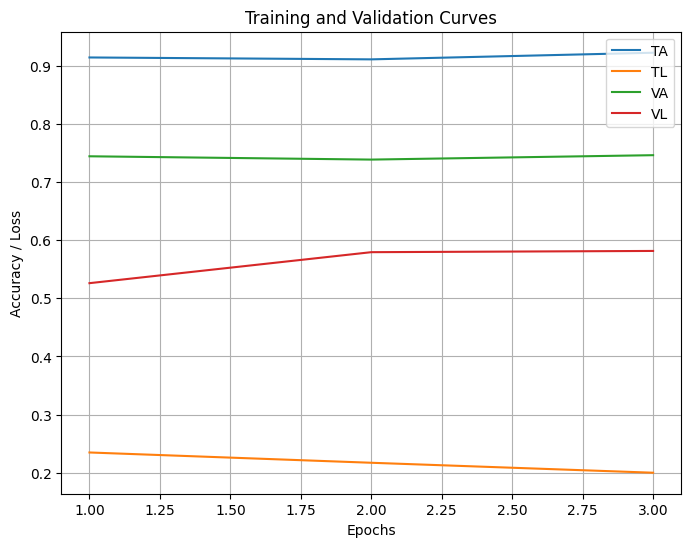

In [45]:
# training.py

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])


def evaluate_on_test(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# arrays to store each metric for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


def train_one_epoch(epoch, model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    print(f"Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    return epoch_loss, epoch_acc

# training loop
for epoch in range(config['epochs']):
    # Train
    train_loss, train_acc = train_one_epoch(epoch, model, train_loader, criterion, optimizer, config['device'])
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # validate (using test_loader as "val_loader" in this example)
    val_loss, val_acc = evaluate_on_test(model, test_loader, criterion, config['device'])
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    
    # ========== log to weights and biases ==========
    wandb.log({
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train Accuracy": train_acc,
        "Val Loss": val_loss,
        "Val Accuracy": val_acc
    })
    
    # save a checkpoint
    checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    wandb.save(checkpoint_path)

# after training, plot TA/TL/VA/VL
epochs_range = range(1, config['epochs'] + 1)

plt.figure(figsize=(8, 6))
# TA = Train Accuracy
plt.plot(epochs_range, train_accuracies, label='TA')
# TL = Train Loss
plt.plot(epochs_range, train_losses, label='TL')
# VA = Validation Accuracy
plt.plot(epochs_range, val_accuracies, label='VA')
# VL = Validation Loss
plt.plot(epochs_range, val_losses, label='VL')

plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Training and Validation Curves')
plt.legend()
plt.grid(True)

plot_path = "training_curves.png"
plt.savefig(plot_path)

# log final plot to wandb
wandb.log({"Training Curves": wandb.Image(plot_path)})
plt.show()


In [38]:
# # evaluation.py
# import torch
# import numpy as np
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# def evaluate(model, loader, device):
#     model.eval()
#     all_preds = []
#     all_labels = []
    
#     with torch.no_grad():
#         for images, labels in loader:
#             images = images.to(device)
#             outputs = model(images)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.numpy())
    
#     all_preds = np.array(all_preds)
#     all_labels = np.array(all_labels)
    
#     acc = accuracy_score(all_labels, all_preds)
#     prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
#     rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
#     f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
#     # calculate specificity for binary classification if applicable
#     cm = confusion_matrix(all_labels, all_preds)
#     if cm.shape == (2, 2):
#         tn, fp, fn, tp = cm.ravel()
#         specificity = tn / (tn + fp + 1e-7)
#     else:
#         specificity = None
    
#     print("Evaluation Metrics:")
#     print(f"Accuracy: {acc:.4f}")
#     print(f"Precision: {prec:.4f}")
#     print(f"Recall (Sensitivity): {rec:.4f}")
#     if specificity is not None:
#         print(f"Specificity: {specificity:.4f}")
#     print(f"F1 Score: {f1:.4f}")

#      # log evaluation metrics to wandb
#     wandb.log({
#         "Test Accuracy": acc,
#         "Precision": prec,
#         "Recall (Sensitivity)": rec,
#         "Specificity": specificity if specificity is not None else 0,
#         "F1-score": f1
#     })

# # run evaluation on the test set
# evaluate(model, test_loader, config['device'])


Evaluation Metrics:
Accuracy: 0.7254
Precision: 0.7221
Recall (Sensitivity): 0.7254
Specificity: 0.5650
F1 Score: 0.7235


Evaluation Metrics:
Accuracy: 0.7462
Precision: 0.7485
Recall (Sensitivity): 0.7462
Specificity: 0.6384
F1 Score: 0.7472

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.64      0.63       177
           1       0.81      0.80      0.81       351

    accuracy                           0.75       528
   macro avg       0.72      0.72      0.72       528
weighted avg       0.75      0.75      0.75       528



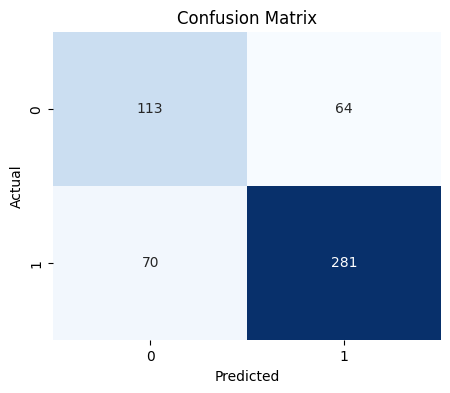

In [46]:
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    # calculate specificity for binary classification if applicable
    cm = confusion_matrix(all_labels, all_preds)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp + 1e-7)
    else:
        specificity = None
    
    print("Evaluation Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall (Sensitivity): {rec:.4f}")
    if specificity is not None:
        print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # ========== CLASSIFICATION REPORT ==========
    report_str = classification_report(all_labels, all_preds, zero_division=0)
    print("\nClassification Report:\n", report_str)
    
    # ========== log evaluation metrics to w&b ==========
    wandb.log({
        "Test Accuracy": acc,
        "Precision": prec,
        "Recall (Sensitivity)": rec,
        # "Specificity": specificity if specificity is not None else 0,
        "Specificity": specificity,
        "F1-score": f1,
        "Classification Report": report_str,  # can store as text
    })
    
    # ========== plot and log confusion matrix ==========
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("Confusion Matrix")
    
    cm_path = "confusion_matrix.png"
    plt.savefig(cm_path)
    
    # log confusion matrix image to wandb
    wandb.log({"confusion_matrix": wandb.Image(cm_path)})
    plt.show()

# evaluate the model on the test set
evaluate(model, test_loader, config['device'])


In [47]:
### Finish your wandb run
run.finish()

Epoch,▁▅█
F1-score,▁
Precision,▁
Recall (Sensitivity),▁
Specificity,▁
Test Accuracy,▁
Train Accuracy,▃▁█
Train Loss,█▄▁
Val Accuracy,▆▁█
Val Loss,▁██
Classification Report,precis...
